# Run on desktop

It would be interesting to use the entire dataset in its original order, and permuted. That sounds like a roos job.

In [1]:
import numpy as np
rnd_gen = np.random.default_rng(2024)
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from online_cp import PluginMartingale
from ucimlrepo import fetch_ucirepo 
from online_cp import ConformalNearestNeighboursClassifier
rnd_gen = np.random.default_rng(2024)

plt.rcParams['svg.fonttype'] = 'none'
from matplotlib_inline.backend_inline import set_matplotlib_formats

# Set the desired output format
set_matplotlib_formats('svg')

from tol_colors import tol_cmap, tol_cset
cmap = tol_cset('bright')

In [2]:
wine_quality = fetch_ucirepo(id=186) 

wine = wine_quality.data.original

X = wine.drop(columns=['quality', 'color']).values
Y = wine['quality'].astype('float').values
# N = 1000
# frac_white = 1/2
# frac_red = 1-frac_white

# reds = wine_quality.data.original[wine_quality.data.original.color == 'red'].sample(int(N*frac_red), random_state=2024)
# whites = wine_quality.data.original[wine_quality.data.original.color == 'white'].sample(int(N*frac_white), random_state=2024)

# # Shuffle the sets (uncomment if we run all data)
# # reds = reds.sample(reds.shape[0], random_state=2024)
# # whites = whites.sample(whites.shape[0], random_state=2024)

# change_point = whites.shape[0]

# X_red = reds.drop(columns=['quality', 'color']).values
# X_white = whites.drop(columns=['quality', 'color']).values
# y_red = reds['quality'].astype('float').values
# y_white = whites['quality'].astype('float').values

# label_space = np.unique(np.concatenate([y_white, y_red]))

In [3]:
# X = np.concatenate([X_white, X_red])
# Y = np.concatenate([y_white, y_red])

X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

label_space = np.unique(Y)

res = np.zeros(shape=(Y.shape[0], 6))
prediction_sets = {}
protected_prediction_sets = {}

cp = ConformalNearestNeighboursClassifier(k=3, label_space=label_space)
protected_cp = ConformalNearestNeighboursClassifier(k=1, label_space=label_space) # Just a dummy to collect the protected results

martingale = PluginMartingale(warnings=False, min_sample_size=10)
calibration_martingale = PluginMartingale(warnings=False, min_sample_size=10)

epsilon = 0.1

p_values_save = np.zeros(shape=(Y.shape[0], 7))
protected_p_values_save = np.zeros(shape=(Y.shape[0], 7))

for i, (obj, lab) in tqdm(enumerate(zip(X, Y)), total=Y.shape[0]):
    
    # Make prediction
    Gamma, p_values, D = cp.predict(obj, epsilon=epsilon, return_p_values=True, return_update=True) 

    p_values_save[i] = np.array([p_values[y] for y in label_space])

    # Apply protection
    protected_p_values = {}
    for label, p in p_values.items():
        protected_p_values[label] = martingale.B_n(p)

    protected_p_values_save[i] = np.array([protected_p_values[y] for y in label_space])

    protected_Gamma = protected_cp._compute_Gamma(p_values=protected_p_values, epsilon=epsilon)

    # Check error
    cp.err(Gamma, lab)
    protected_cp.err(protected_Gamma, lab)

    # Learn the label
    cp.learn_one(obj, lab, D)

    # Update martingale
    martingale.update_martingale_value(p_values[lab])
    calibration_martingale.update_martingale_value(protected_p_values[lab])

    # Prefferred efficiency criteria

    # Observed excess
    cp.oe(Gamma, lab)
    protected_cp.oe(protected_Gamma, lab)

    # Observed fuzziness
    cp.of(p_values, lab)
    protected_cp.of(protected_p_values, lab)


    res[i, 0] = cp.OE
    res[i, 1] = cp.OF
    res[i, 2] = cp.Err
    prediction_sets[i] = Gamma
    res[i, 3] = protected_cp.OE
    res[i, 4] = protected_cp.OF
    res[i, 5] = protected_cp.Err
    protected_prediction_sets[i] = protected_Gamma

  0%|          | 0/6497 [00:00<?, ?it/s]

/media/joha5534/suhome/Documents/online-cp/src/online_cp/classifiers.py:287: RuntimeWarning: divide by zero encountered in divide
  Alpha = np.nan_to_num(same_label_distances / different_label_distances, nan=np.inf)


In [16]:
import pandas as pd
columns = list(label_space)
df_p_values = pd.DataFrame(p_values_save, columns=columns)
df_protected_p_values = pd.DataFrame(protected_p_values_save, columns=columns)
df_p_values['label'] = Y
df_protected_p_values['label'] = Y


df_p_values.to_csv('data_protected_conformal_classification/wine_original_order_p_values.csv', index=False)
df_protected_p_values.to_csv('wine_original_order_protected_p_values.csv', index=False)

In [5]:
print(f'Base error rate: {cp.Err/Y.shape[0]}')
print(f'Protected error rate: {protected_cp.Err/Y.shape[0]}')

Base error rate: 0.10235493304602124
Protected error rate: 0.09404340464829922


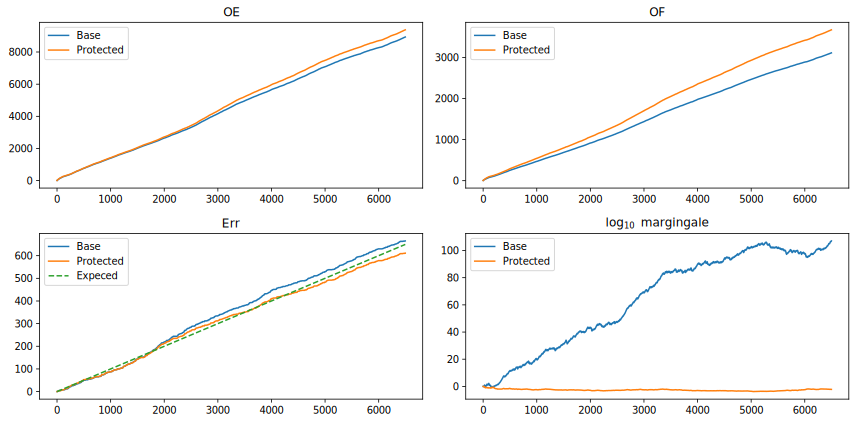

In [6]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 6))
ax[0, 0].plot(res[:, 0], label='Base')
ax[0, 0].plot(res[:, 3], label='Protected')
#ax[0, 0].axvline(change_point, label='Change point', linestyle='--', color='red')
ax[0, 0].set_title('OE')
ax[0, 0].legend()

ax[0, 1].plot(res[:, 1], label='Base')
ax[0, 1].plot(res[:, 4], label='Protected')
#ax[0, 1].axvline(change_point, label='Change point', linestyle='--', color='red')
ax[0, 1].set_title('OF')
ax[0, 1].legend()

ax[1, 0].plot(res[:, 2], label='Base')
ax[1, 0].plot(res[:, 5], label='Protected')
#ax[1, 0].axvline(change_point, label='Change point', linestyle='--', color='red')
# ax[1, 0].plot(rnd_gen.binomial(n=1, p=0.1, size=Y.shape[0]).cumsum(), linestyle='--', label='Cumulative Bernoulli')
ax[1, 0].plot(list(epsilon*i for i in range(X.shape[0])), linestyle='--', label='Expeced')
ax[1, 0].set_title('Err')
ax[1, 0].legend()

ax[1, 1].plot(martingale.log10_martingale_values, label='Base')
ax[1, 1].plot(calibration_martingale.log10_martingale_values, label='Protected')
#ax[1, 1].axvline(change_point, label='Change point', linestyle='--', color='red')
ax[1, 1].set_title(r'$\log_{10}$' + ' margingale')
ax[1, 1].legend()

fig.tight_layout()
fig.savefig('wine_original_order.pdf')

In [7]:
martingale.max, calibration_martingale.max

(1.1508824200081622e+107, 1.019007434662201)

# Price of protection

In [8]:
cp.OE/Y.shape[0], protected_cp.OE/Y.shape[0]

(1.375096198245344, 1.443743266122826)

In terms of observed excess

In [9]:
protected_cp.OE - cp.OE

446

In terms of observed fuzziness

In [10]:
protected_cp.OF - cp.OF

560.6436542901197

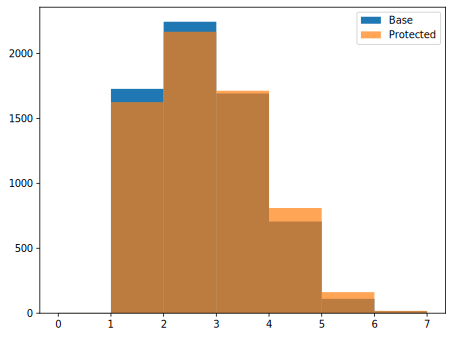

In [11]:
sizes = np.zeros_like(Y)
for j, val in enumerate(prediction_sets.values()):
    sizes[j] = len(val)

protected_sizes = np.zeros_like(Y)
for j, val in enumerate(protected_prediction_sets.values()):
    protected_sizes[j] = len(val)

plt.hist(sizes, bins=label_space.shape[0], label='Base')
plt.hist(protected_sizes, bins=label_space.shape[0], alpha=0.7, label='Protected')
plt.legend()
plt.tight_layout()
plt.savefig('wine_original_order_sizes.pdf')

In [12]:
# plt.hist(martingale.p_values[change_point:], density=True)
# plt.hist(calibration_martingale.p_values[:change_point], density=True, alpha=0.7)

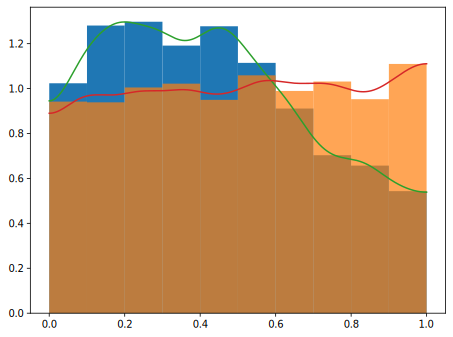

In [13]:
plt.hist(martingale.p_values, density=True)
plt.hist(calibration_martingale.p_values, density=True, alpha=0.7)
xrange = np.linspace(0, 1, endpoint=True, num=1000)
plt.plot(xrange, martingale.b_n(xrange))
plt.plot(xrange, calibration_martingale.b_n(xrange))
plt.tight_layout()
plt.savefig('wine_original_order_hist.pdf')

# We have saved the p-values, so let's check all $\varepsilon$

In [14]:
df_p_values = pd.read_csv('wine_original_order_p_values.csv')
df_protected_p_values = pd.read_csv('wine_original_order_protected_p_values.csv')
# FIXME: Below, the label space should be the columns...

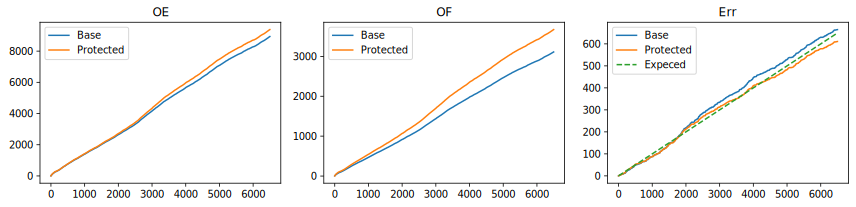

In [15]:
epsilon = 0.1
cp_post = ConformalNearestNeighboursClassifier(k=1, label_space=df_p_values.columns[:-1]) # Just a dummy to collect the protected results
cp_post_protected = ConformalNearestNeighboursClassifier(k=1, label_space=df_protected_p_values.columns[:-1]) # Just a dummy to collect the protected results

res = np.zeros(shape=(Y.shape[0], 6))

for (i, row), (_, protected_row) in zip(df_p_values.iterrows(), df_protected_p_values.iterrows()):
    p_values = row.to_dict()
    lab = str(p_values.pop('label'))
    Gamma = cp_post._compute_Gamma(p_values=p_values, epsilon=epsilon)

    protected_p_values = protected_row.to_dict()
    protected_p_values.pop('label')
    protected_Gamma = cp_post_protected._compute_Gamma(p_values=protected_p_values, epsilon=epsilon)

    # Check error
    cp_post.err(Gamma, lab)
    cp_post_protected.err(protected_Gamma, lab)

    # Prefferred efficiency criteria

    # Observed excess
    cp_post.oe(Gamma, lab)
    cp_post_protected.oe(protected_Gamma, lab)

    # Observed fuzziness
    cp_post.of(p_values, lab)
    cp_post_protected.of(protected_p_values, lab)


    res[i, 0] = cp_post.OE
    res[i, 1] = cp_post.OF
    res[i, 2] = cp_post.Err
    res[i, 3] = cp_post_protected.OE
    res[i, 4] = cp_post_protected.OF
    res[i, 5] = cp_post_protected.Err

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12, 3))
ax[0].plot(res[:, 0], label='Base')
ax[0].plot(res[:, 3], label='Protected')
#ax[0, 0].axvline(change_point, label='Change point', linestyle='--', color='red')
ax[0].set_title('OE')
ax[0].legend()

ax[1].plot(res[:, 1], label='Base')
ax[1].plot(res[:, 4], label='Protected')
ax[1].set_title('OF')
ax[1].legend()

ax[2].plot(res[:, 2], label='Base')
ax[2].plot(res[:, 5], label='Protected')
ax[2].plot(list(epsilon*i for i in range(X.shape[0])), linestyle='--', label='Expeced')
ax[2].set_title('Err')
ax[2].legend()

fig.tight_layout()
# fig.savefig('wine_original_order.pdf')